In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV



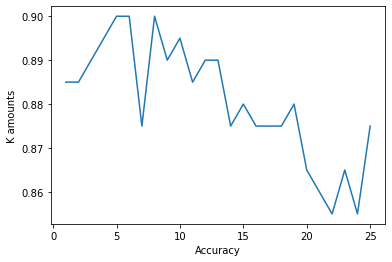

Pontosság: 0.9


In [147]:
# Adatok beolvasása
data = pd.read_csv('adatszet_B_csoport.csv')
X = data.iloc[:, 0:-1].values # Feauture szett kinyerése és np.array-é alakítása
y = data.iloc[:, -1].values # Label kinyerése és np.array-é alakítása

# y mint adatok nem alkalmasak osztályozásra, ezért át kell alakítani
# Ezzel a beépített cumóval oldom meg, hogy osztályozhatóvá alakítsam az y oszlop adatait, mert floatban nem jóóóó
lab = preprocessing.LabelEncoder()
y = lab.fit_transform(y)

# Tanító és teszt adatok felbontása, test_size a teszt adatok nagysága %-ban
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69)

# Legjobb szomszédszám megkeresése
scores = []

for i in range(1,26): # 1 és 26 db szomszéddal csekkoljuk a knn-t
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train) # tanítás
    y_pred = knn.predict(X_test) # prediktelés
    scores.append(accuracy_score(y_test, y_pred)) # értékelés

# Vizuálisan kirajzolom a szomszédok eredményét
plt.plot(range(1,26), scores)
plt.xlabel('Accuracy') # x tengely neve
plt.ylabel('K amounts') # y tengely neve
plt.show()

# KNN tanítása ajánlott páratlan szomszéd beállítása
knn = KNeighborsClassifier(n_neighbors=5) # KNN 5 szomszéddal való dolgozása
knn.fit(X_train, y_train) # Betanítás
y_pred = knn.predict(X_test) # Predictelés
print('Pontosság:',accuracy_score(y_test, y_pred)) # Pontosság meghatározás


In [148]:
# Random Forest, random_state egy valamely kiválasztott random állapot,
# ha 69 helyett 420-at írok akkor kicsit más eredményt jönne ki speciel
# n_estimators=DecisionTree darabszám, random_state=69, max_features=maximum hány függő oszlopa lehet?
rfc = RandomForestClassifier(n_estimators=100, random_state=69, max_features=3)

# Cross Validation, ezzel egy szebb/valósabb eredmény jön ki mert cv számszor futtatjuk le a modellt
# létrehozott modell, feature, label, hány db modell
results = cross_val_score(rfc, X, y, cv=10)
print('Random Forest with cross val:', results.mean()) # Ezt átlagoljuk egy összesített eredményért

Random Forest with cross val: 0.913


In [149]:
# SVC
# SVM betanítása és predictálás
# Kernel: Átalakítja az adathalmazt, hogy tudjon vonalat tenni, 
        # amivel majd szétválaszthatjuk az adathalmazt több részre.
        # A lineáris kernel van a képeken, pl a margós képen      
# Reguralization: Ezzel határozzuk meg, hogy mennyire durván büntessünk grr~
# Gamma: Alacsonyabb gamma érték inkább alultanít, magasabb meg túltanit. Arany középút
# Hiperparaméterek meghatározása. Több adattal dolgozunk, hogy majd a legjobb kombót megkapjuk
param_grid = {'C': [0.1, 1, 10, 100, 1000],
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
'kernel': ['rbf']} # 'linear', 'sigmoid', így is az rbf volt a legjobb
# GridSearchCV a param_grid-ben a kernel, gamma, C sorok összes kombinációját lefuttatja
# verbose: 1 -> számítási időt kiírja, 2 -> idő + pontosság, 3 -> idő + pontosság + paraméter indexek stb.
grid = GridSearchCV(SVC(), param_grid, verbose=1)
grid.fit(X_train, y_train)
# Legjobb paraméter kiírása
print('Legjobb paraméter:',grid.best_params_)

# Legjobb paraméterrel dolgozás
grid_predictions = SVC(kernel='rbf', C=100, gamma=0.01)

# Pontozás
results = cross_val_score(grid_predictions, X, y, cv=10)
print('GridSearchCV with cross val:', results.mean())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Legjobb paraméter: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
GridSearchCV with cross val: 0.9269999999999999


VotingClassifier with cross val: 0.915
Tradicionális pontosság:  0.9


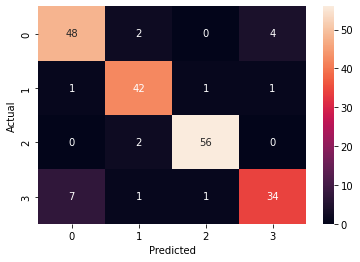

In [150]:
# VotingClassifier
# Ebben tároljuk a különböző modelleket. 
estimators = []
# Tuple formátumban kell feltölteni a tömböt, mert így jó csak a VotingClassifier ('knn', knn)
estimators.append(('knn', knn))
estimators.append(('rfc', rfc))
estimators.append(('svc', svc))

# A VotingClassifier-be kell bele tenni a tuple formátumokat 
ensembleVC = VotingClassifier(estimators=estimators) # Csak tuple formátumot fogad el
results = cross_val_score(ensembleVC, X, y, cv=10) # Ezt már leírtam
print('VotingClassifier with cross val:',results.mean())

# Konfúziós mátrixxal a pontosság kimutatása, rownames = y tengely neve, colnames = x tengely neve
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
# Konfúziós mátrix (heatmap) kirajzolása (adathalmaz, hőkép színpalettája, interpoláció fajta)
sns.heatmap(confusion_matrix, annot=True) # annot = legyen-e szám rajta
print('Tradicionális pontosság: ',accuracy_score(y_test, y_pred)) # Pontosság



In [151]:
# Értékelés: Elég pacek a 91.5% bár önmagában a hiperparaméter optimalizált SVC kicsit jobb a 92.7%-al
# Szóval a GridSearchCV a legjobb nekem, de ugye lassú
# 2. a szavazós, pedig ennek kéne az 1.-nek lennie, de sebaj
# 3. Random Forest
# 4. KNN
# De mindegyik pacek a 90%+-al.

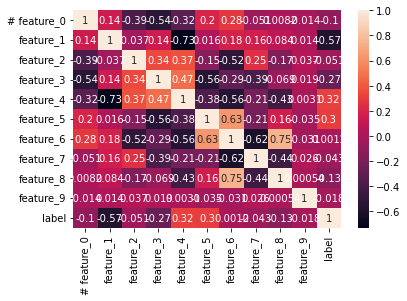

Alapértelmezett adatszet hossza: 1000
Duplikált sorokkal kitörölve: 1000


In [152]:
# Extra feladat
# Korreláció csekkolása korrelációs mátrixxal
sns.heatmap(data.corr(), annot=True) # annot=True => számok kiírása
plt.show()
# Vizsgálat eredménye: Szimmetrikus a mátrix, ergó az adatok fele duplikáció?
# UI: Mégsincs redundáns sor a data.duplicated szerint.

# Ugyanolyan/duplikált sorok keresése és kitörlése (keep=False)
print("Alapértelmezett adatszet hossza:", len(data))
print("Duplikált sorokkal kitörölve:", len(data.duplicated(keep=False)))